## Neural Network for molecules solubility

To avoid repetition, I will add already the engineered features obtained in the other notebooks, to start with a better dataset.

In [1]:
import pandas as pd
from rdkit.Chem import Descriptors
from rdkit import Chem

from src.utils import show_accuracy

# Reading csv
sol_df = pd.read_csv("data/delaney-processed.csv")

# First create the molecule object for each entry
sol_df["rdkit_mol"] = sol_df["smiles"].apply(Chem.MolFromSmiles)

# Then use that to extract other features with RDkit
sol_df["MolLogP"] = sol_df["rdkit_mol"].apply(Descriptors.MolLogP)
sol_df["MolMR"] = sol_df["rdkit_mol"].apply(Descriptors.MolMR)
sol_df["HeavyAtomCount"] = sol_df["rdkit_mol"].apply(Descriptors.HeavyAtomCount)
sol_df["FractionCSP3"] = sol_df["rdkit_mol"].apply(Descriptors.FractionCSP3)
sol_df["TPSA"] = sol_df["rdkit_mol"].apply(Descriptors.TPSA)
sol_df["NumAromaticRings"] = sol_df["rdkit_mol"].apply(Descriptors.NumAromaticRings)
sol_df["NumHDonors"] = sol_df["rdkit_mol"].apply(Descriptors.NumHDonors)
sol_df["NumHAcceptors"] = sol_df["rdkit_mol"].apply(Descriptors.NumHAcceptors)

rel_features = [
    "Molecular Weight",
    "Minimum Degree",
    "Number of H-Bond Donors",
    "Number of Rings",
    "Number of Rotatable Bonds",
    "Polar Surface Area",
    "MolLogP",
    "MolMR",
    "HeavyAtomCount",
    "FractionCSP3",
    "TPSA",
    "NumAromaticRings",
    "NumHDonors",
    "NumHAcceptors",
]
target = "measured log solubility in mols per litre"

#### Prepare the datasets

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = sol_df[rel_features].values
y = sol_df[target].values.reshape(-1, 1)

# Scale features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


#### Create the NN

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class SolubilityNN(nn.Module):
    def __init__(self, input_size):
        super(SolubilityNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # input_size is the number of input features
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)  # To avoid overfitting

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SolubilityNN(input_size=X.shape[1])

#### Train it

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

# Training
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")


Epoch 10/100, Loss: 0.0336
Epoch 20/100, Loss: 0.0274
Epoch 30/100, Loss: 0.0349
Epoch 40/100, Loss: 0.0614
Epoch 50/100, Loss: 0.0159
Epoch 60/100, Loss: 0.0872
Epoch 70/100, Loss: 0.0333
Epoch 80/100, Loss: 0.0210
Epoch 90/100, Loss: 0.0050
Epoch 100/100, Loss: 0.0047


#### Evaluate it

R^2: 0.8877
RMSE: 0.7285


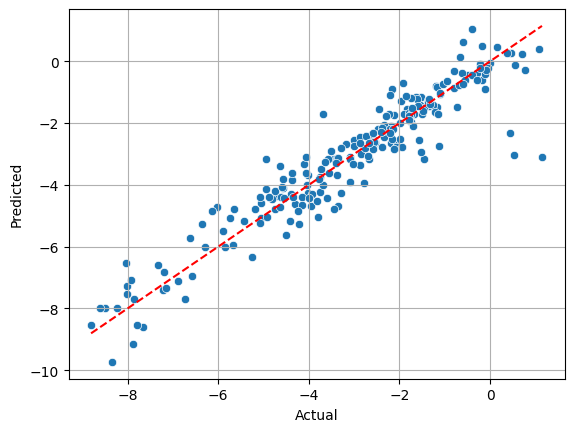

In [33]:
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy()
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

show_accuracy(y_pred=y_pred.flatten(), y_test=y_true.flatten())

# Work in progress